In [1]:
# Setup & Imports
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 # OpenCV for image loading/resizing
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from PIL import Image

# Render plots inline
%matplotlib inline

BASE_DIR = r"E:\brisc2025"
print("✅ BASE_DIR =", BASE_DIR)


✅ BASE_DIR = E:\brisc2025


In [2]:
# Directory Tree
def walk_dir(base, max_depth=2):
    for root, dirs, _ in os.walk(base):
        depth = root.replace(base, "").count(os.sep)
        if depth <= max_depth:
            indent = "  " * depth
            print(f"{indent}{os.path.basename(root)}/")
            for d in dirs:
                print(f"{indent}  {d}/")

print("## BRISC2025 Folder Layout:")
walk_dir(BASE_DIR, max_depth=2)

## BRISC2025 Folder Layout:
brisc2025/
  classification_task/
  segmentation_task/
  classification_task/
    test/
    train/
    test/
      glioma/
      meningioma/
      no_tumor/
      pituitary/
    train/
      glioma/
      meningioma/
      no_tumor/
      pituitary/
  segmentation_task/
    test/
    train/
    test/
      images/
      masks/
    train/
      images/
      masks/


In [3]:
# File Count Logic 
def count_patterns(patterns):
    return sum(len(glob.glob(p)) for p in patterns)

# Classification
splits = ["train", "test"]
classes = ["glioma", "meningioma", "pituitary", "no_tumor"]
cls_records = []
for sp in splits:
    total = 0
    for cls in classes:
        pat = os.path.join(BASE_DIR, "classification_task", sp, cls, "*.jpg")
        cnt = count_patterns([pat])
        cls_records.append({'Split': sp, 'Class': cls, 'Count': cnt})
        total += cnt
    cls_records.append({'Split': sp, 'Class': 'Total', 'Count': total})
df_cls = pd.DataFrame(cls_records)

# Segmentation
types_ = ["images", "masks"]
seg_records = []
for sp in splits:
    for tp in types_:
        pats = [
            os.path.join(BASE_DIR, "segmentation_task", sp, tp, "*.jpg"),
            os.path.join(BASE_DIR, "segmentation_task", sp, tp, "*.png")
        ]
        cnt = count_patterns(pats)
        seg_records.append({'Split': sp, 'Type': tp, 'Count': cnt})
df_seg = pd.DataFrame(seg_records)

# Display
print("### Classification Counts")
display(df_cls)
print("### Segmentation Counts")
display(df_seg)

### Classification Counts


,Split,Class,Count
0,train,glioma,1147
1,train,meningioma,1329
2,train,pituitary,1457
3,train,no_tumor,1067
4,train,Total,5000
5,test,glioma,254
6,test,meningioma,306
7,test,pituitary,300
8,test,no_tumor,140
9,test,Total,1000


### Segmentation Counts


,Split,Type,Count
0,train,images,3933
1,train,masks,3933
2,test,images,860
3,test,masks,860


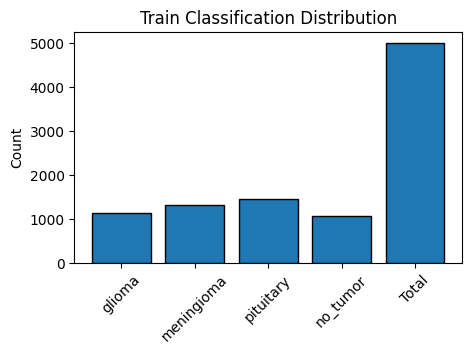

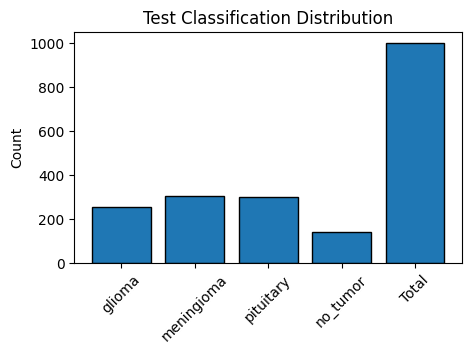

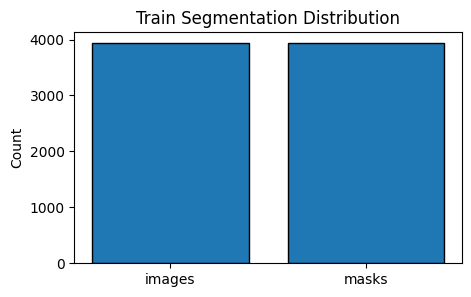

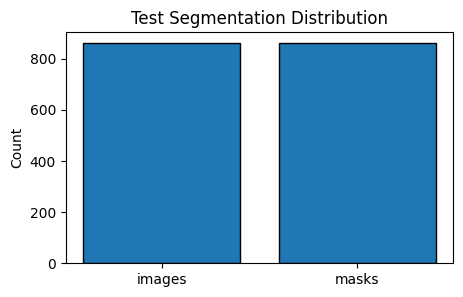

In [4]:
# Distribution Plots
for sp in splits:
    sub = df_cls[df_cls.Split==sp]
    plt.figure(figsize=(5,3))
    plt.bar(sub.Class, sub.Count, edgecolor='k')
    plt.title(f"{sp.title()} Classification Distribution")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

for sp in splits:
    sub = df_seg[df_seg.Split==sp]
    plt.figure(figsize=(5,3))
    plt.bar(sub.Type, sub.Count, edgecolor='k')
    plt.title(f"{sp.title()} Segmentation Distribution")
    plt.ylabel("Count")
    plt.show()

In [5]:
# Per‑Plane Counts
planes = ["ax", "co", "sa"]
plane_records = []

for sp in splits:
    for cls in classes:
        for pl in planes:
            pat = os.path.join(
                BASE_DIR, "classification_task", sp, cls, f"*_{pl}_t1.jpg"
            )
            cnt = count_patterns([pat])
            plane_records.append({'Split': sp, 'Class': cls, 'Plane': pl, 'Count': cnt})

df_plane = pd.DataFrame(plane_records)
print("### Per‑Plane Counts Pivot")
display(df_plane.pivot_table(index='Plane', columns=['Split','Class'], values='Count'))

### Per‑Plane Counts Pivot


Split   test                                train                      \
Class glioma meningioma no_tumor pituitary glioma meningioma no_tumor   
Plane                                                                   
ax      85.0      137.0     52.0     124.0  394.0      423.0    352.0   
co      81.0       86.0     48.0      90.0  430.0      426.0    310.0   
sa      88.0       83.0     40.0      86.0  323.0      480.0    405.0   

Split            
Class pituitary  
Plane            
ax        426.0  
co        510.0  
sa        521.0

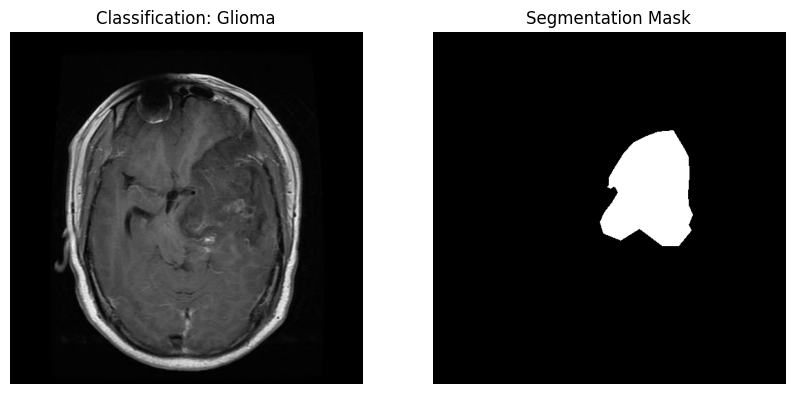

In [6]:
# Sample Visualization
def first_file(folder, exts):
    for ext in exts:
        fl = glob.glob(os.path.join(folder, f"*.{ext}"))
        if fl: return fl[0]
    return None

img_path  = first_file(os.path.join(BASE_DIR, "classification_task/train/glioma"), ["jpg"])
mask_path = first_file(os.path.join(BASE_DIR, "segmentation_task/train/masks"), ["png","jpg"])

img  = Image.open(img_path)
mask = Image.open(mask_path)

fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].imshow(img,  cmap="gray"); axes[0].set_title("Classification: Glioma"); axes[0].axis("off")
axes[1].imshow(mask, cmap="gray"); axes[1].set_title("Segmentation Mask");    axes[1].axis("off")
plt.show()

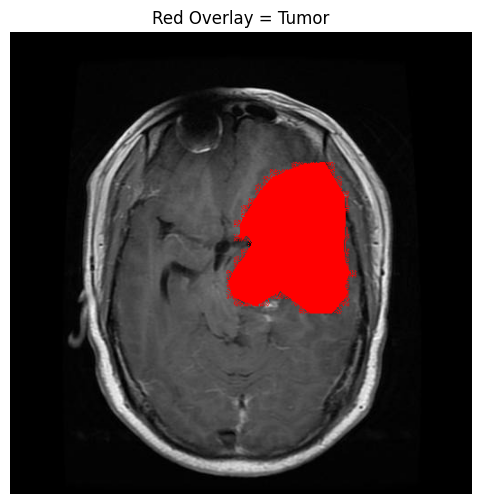

In [7]:
# Overlay
img_rgb  = np.array(img.convert("RGB"))
mask_arr = np.array(mask)

overlay = img_rgb.copy()
overlay[mask_arr>0] = [255,0,0]

plt.figure(figsize=(6,6))
plt.imshow(overlay); plt.title("Red Overlay = Tumor"); plt.axis("off")
plt.show()

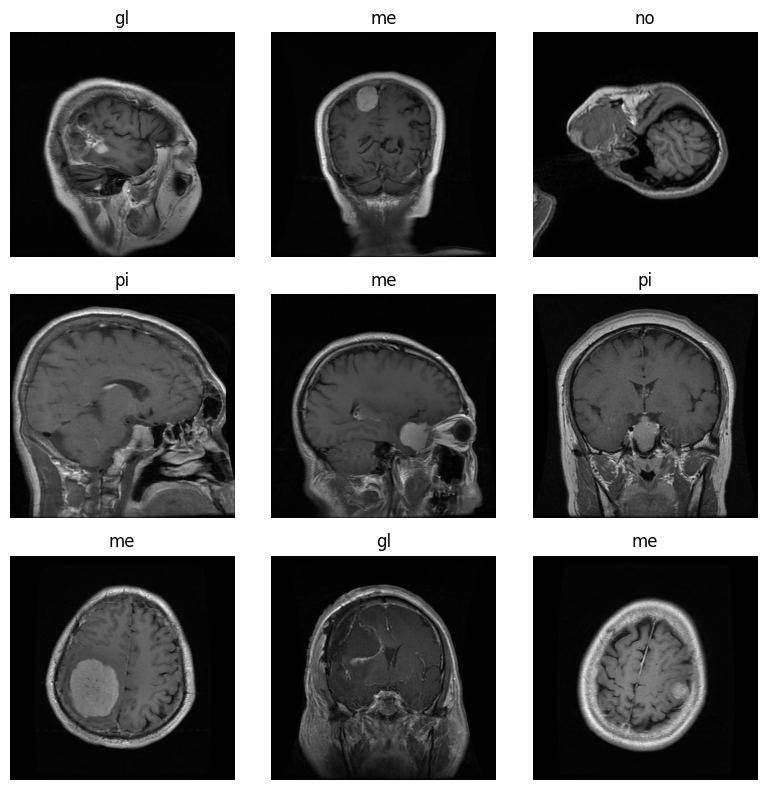

In [8]:
# Random Grid
samples = glob.glob(os.path.join(BASE_DIR, "classification_task/train/*/*.jpg"))
grid = np.random.choice(samples, 9, replace=False)

fig, axes = plt.subplots(3,3, figsize=(8,8))
axes = axes.flatten()
for ax, fp in zip(axes, grid):
    im = Image.open(fp)
    cls = os.path.basename(fp).split("_")[3]
    ax.imshow(im, cmap="gray")
    ax.set_title(cls)
    ax.axis("off")
plt.tight_layout()
plt.show()

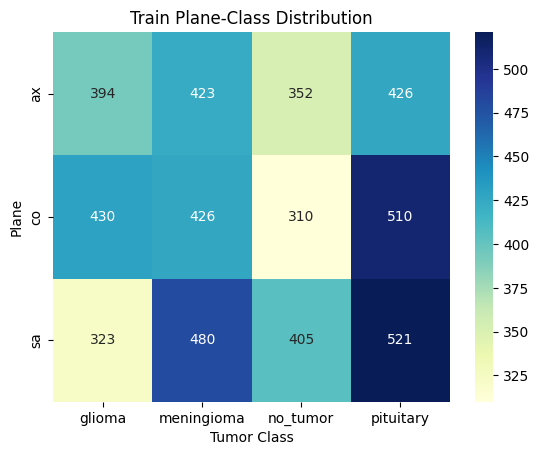

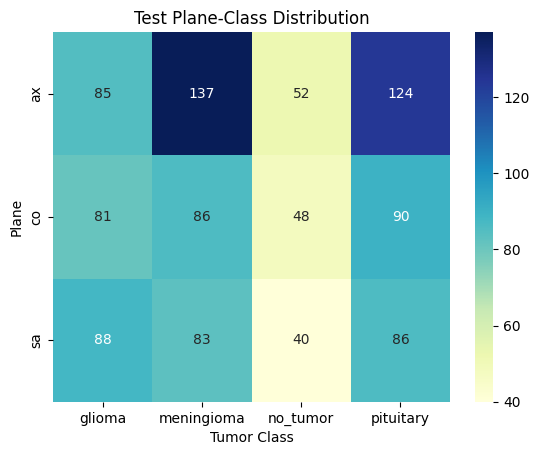

In [9]:
# Per-Plane Heatmaps

# Manually defined counts from your pivot table
plane_counts = {
    'train': {
        'glioma': [394, 430, 323],
        'meningioma': [423, 426, 480],
        'no_tumor': [352, 310, 405],
        'pituitary': [426, 510, 521]
    },
    'test': {
        'glioma': [85, 81, 88],
        'meningioma': [137, 86, 83],
        'no_tumor': [52, 48, 40],
        'pituitary': [124, 90, 86]
    }
}
planes = ['ax', 'co', 'sa']

def plot_plane_heatmap(split):
    df = pd.DataFrame(plane_counts[split], index=planes)
    sns.heatmap(df, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f'{split.capitalize()} Plane-Class Distribution')
    plt.xlabel('Tumor Class')
    plt.ylabel('Plane')
    plt.show()

plot_plane_heatmap('train')
plot_plane_heatmap('test')



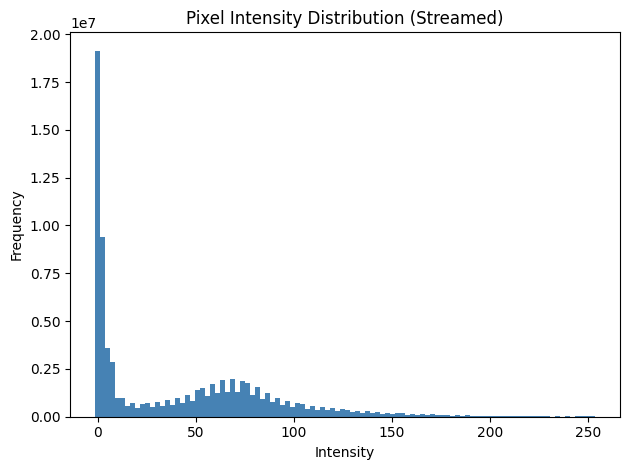

In [10]:
# Histograms

def collect_image_paths(base_dir, subset='train'):
    paths = []
    for cls in ['glioma', 'meningioma', 'no_tumor', 'pituitary']:
        cls_dir = os.path.join(base_dir, 'classification_task', subset, cls)
        for fname in os.listdir(cls_dir):
            if fname.endswith('.jpg') or fname.endswith('.png'):
                paths.append(os.path.join(cls_dir, fname))
    return paths

def plot_intensity_histogram_streamed(image_paths, resize_to=(128, 128), bins=100):
    hist_accum = np.zeros(bins)
    bin_edges = None

    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            if resize_to:
                img = cv2.resize(img, resize_to)
            hist, edges = np.histogram(img, bins=bins, range=(0, 255))
            hist_accum += hist
            if bin_edges is None:
                bin_edges = edges

    plt.bar(bin_edges[:-1], hist_accum, width=(bin_edges[1] - bin_edges[0]), color='steelblue')
    plt.title('Pixel Intensity Distribution (Streamed)')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

image_paths = collect_image_paths(BASE_DIR, subset='train')
plot_intensity_histogram_streamed(image_paths, resize_to=(128, 128), bins=100)



In [11]:
# Checking Dimensions of all the images

from collections import Counter

def summarize_image_dimensions(image_paths):
    dim_counter = Counter()
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            dim_counter[img.shape] += 1
    return dim_counter
dimension_summary = summarize_image_dimensions(image_paths)

# Print summary
for dim, count in dimension_summary.items():
    print(f"Dimension {dim}: {count} images")

Dimension (512, 512): 4120 images
Dimension (237, 213): 2 images
Dimension (500, 455): 3 images
Dimension (270, 250): 1 images
Dimension (546, 472): 1 images
Dimension (427, 441): 1 images
Dimension (510, 485): 2 images
Dimension (605, 507): 1 images
Dimension (345, 338): 1 images
Dimension (554, 554): 2 images
Dimension (398, 369): 1 images
Dimension (650, 591): 1 images
Dimension (398, 351): 1 images
Dimension (377, 341): 1 images
Dimension (624, 491): 1 images
Dimension (358, 314): 1 images
Dimension (307, 257): 1 images
Dimension (223, 200): 2 images
Dimension (345, 300): 1 images
Dimension (340, 291): 1 images
Dimension (354, 318): 1 images
Dimension (341, 315): 1 images
Dimension (306, 278): 1 images
Dimension (442, 442): 6 images
Dimension (522, 513): 1 images
Dimension (401, 312): 1 images
Dimension (412, 300): 1 images
Dimension (251, 205): 1 images
Dimension (249, 204): 1 images
Dimension (342, 323): 1 images
Dimension (216, 216): 1 images
Dimension (372, 341): 1 images
Dimen

In [12]:
# Resize and saving 


def resize_and_save_images(src_base, dst_base, target_size=(128, 128)):
    for split in ['train', 'test']:
        for cls in ['glioma', 'meningioma', 'no_tumor', 'pituitary']:
            src_dir = os.path.join(src_base, 'classification_task', split, cls)
            dst_dir = os.path.join(dst_base, 'classification_task', split, cls)
            os.makedirs(dst_dir, exist_ok=True)

            for fname in os.listdir(src_dir):
                if fname.endswith('.jpg') or fname.endswith('.png'):
                    src_path = os.path.join(src_dir, fname)
                    dst_path = os.path.join(dst_dir, fname)

                    img = cv2.imread(src_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img_resized = cv2.resize(img, target_size)
                        cv2.imwrite(dst_path, img_resized)


def resize_segmentation_pairs(src_base, dst_base, target_size=(128, 128)):
    for split in ['train', 'test']:
        img_src_dir = os.path.join(src_base, 'segmentation_task', split, 'images')
        mask_src_dir = os.path.join(src_base, 'segmentation_task', split, 'masks')

        img_dst_dir = os.path.join(dst_base, 'segmentation_task', split, 'images')
        mask_dst_dir = os.path.join(dst_base, 'segmentation_task', split, 'masks')

        os.makedirs(img_dst_dir, exist_ok=True)
        os.makedirs(mask_dst_dir, exist_ok=True)

        # Build a map of mask files by base name
        mask_files = {os.path.splitext(f)[0]: f for f in os.listdir(mask_src_dir) if f.endswith('.png')}

        for img_fname in os.listdir(img_src_dir):
            if img_fname.endswith('.jpg'):
                base_name = os.path.splitext(img_fname)[0]
                mask_fname = mask_files.get(base_name)

                if mask_fname:
                    img_path = os.path.join(img_src_dir, img_fname)
                    mask_path = os.path.join(mask_src_dir, mask_fname)

                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

                    if img is not None and mask is not None:
                        img_resized = cv2.resize(img, target_size)
                        mask_resized = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

                        cv2.imwrite(os.path.join(img_dst_dir, img_fname), img_resized)
                        cv2.imwrite(os.path.join(mask_dst_dir, mask_fname), mask_resized)
                else:
                    print(f"No matching mask for image: {img_fname}")
# Usage
SRC_DIR = r"E:\brisc2025"
DST_DIR = r"E:\brisc2025_resized_128"
resize_and_save_images(SRC_DIR, DST_DIR)
resize_segmentation_pairs(SRC_DIR, DST_DIR)

In [13]:
# Applying CLAHE and Zscore_Normalization

# CLAHE enhancement
def apply_clahe(img, clip_limit=2.0, tile_grid_size=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(img)

# Z-score normalization
def zscore_normalize(img):
    img = img.astype('float32')
    mean, std = img.mean(), img.std()
    img = (img - mean) / std if std > 0 else img - mean
    img = ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)
    return img

# Full preprocessing pipeline
def preprocess_mri_image(path, size=(128, 128), normalize=True):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not found: {path}")
    
    img = cv2.resize(img, size)
    img = apply_clahe(img)

    if normalize:
        img = zscore_normalize(img)

    return img

# Enhance classification images
def enhance_classification_images(resized_base_dir, output_base_dir, normalize=True):
    for split in ['train', 'test']:
        for cls in ['glioma', 'meningioma', 'no_tumor', 'pituitary']:
            src_dir = os.path.join(resized_base_dir, 'classification_task', split, cls)
            dst_dir = os.path.join(output_base_dir, 'classification_task', split, cls)
            os.makedirs(dst_dir, exist_ok=True)

            for fname in os.listdir(src_dir):
                if fname.lower().endswith(('.jpg', '.png')):
                    src_path = os.path.join(src_dir, fname)
                    dst_path = os.path.join(dst_dir, fname)

                    try:
                        enhanced_img = preprocess_mri_image(src_path, size=(128, 128), normalize=normalize)
                        cv2.imwrite(dst_path, enhanced_img)
                    except Exception as e:
                        print(f"Error processing {src_path}: {e}")

# Enhance segmentation images and copy masks
def enhance_segmentation_images(resized_base_dir, output_base_dir, normalize=True):
    for split in ['train', 'test']:
        img_src_dir = os.path.join(resized_base_dir, 'segmentation_task', split, 'images')
        mask_src_dir = os.path.join(resized_base_dir, 'segmentation_task', split, 'masks')

        img_dst_dir = os.path.join(output_base_dir, 'segmentation_task', split, 'images')
        mask_dst_dir = os.path.join(output_base_dir, 'segmentation_task', split, 'masks')

        os.makedirs(img_dst_dir, exist_ok=True)
        os.makedirs(mask_dst_dir, exist_ok=True)

        for fname in os.listdir(img_src_dir):
            if fname.lower().endswith(('.jpg', '.png')):
                src_path = os.path.join(img_src_dir, fname)
                dst_path = os.path.join(img_dst_dir, fname)

                try:
                    enhanced_img = preprocess_mri_image(src_path, size=(128, 128), normalize=normalize)
                    cv2.imwrite(dst_path, enhanced_img)
                except Exception as e:
                    print(f"Error processing {src_path}: {e}")

        # Copy masks without modification
        for fname in os.listdir(mask_src_dir):
            if fname.lower().endswith(('.png', '.jpg')):
                src_mask_path = os.path.join(mask_src_dir, fname)
                dst_mask_path = os.path.join(mask_dst_dir, fname)

                try:
                    mask = cv2.imread(src_mask_path, cv2.IMREAD_GRAYSCALE)
                    if mask is not None:
                        cv2.imwrite(dst_mask_path, mask)
                except Exception as e:
                    print(f"Error copying mask {src_mask_path}: {e}")


                    
# Run the enhancement
RESIZED_DIR = r"E:\brisc2025_resized_128"
ENHANCED_DIR = r"E:\brisc2025_enhanced_128"

enhance_classification_images(RESIZED_DIR, ENHANCED_DIR, normalize=True)
enhance_segmentation_images(RESIZED_DIR, ENHANCED_DIR, normalize=True)

In [14]:
# Training phase

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from sklearn.model_selection import train_test_split

In [16]:
class SegmentationDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = cv2.imread(row['image_path'], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(row['mask_path'], cv2.IMREAD_GRAYSCALE)
    
        if image is None:
            raise FileNotFoundError(f"Image not found: {row['image_path']}")
        if mask is None:
            raise FileNotFoundError(f"Mask not found: {row['mask_path']}")
    
        image = np.expand_dims(image, axis=0).astype(np.float32) / 255.0
        mask = (mask > 127).astype(np.float32)
        mask = np.expand_dims(mask, axis=0)
    
        return torch.tensor(image), torch.tensor(mask)



In [17]:
seg_root = r"E:\brisc2025_enhanced_128\segmentation_task\train"
seg_records = []

for fname in os.listdir(os.path.join(seg_root, "images")):
    image_id = fname  # e.g. image_001.jpg
    image_path = os.path.join(seg_root, "images", fname)
    mask_path = os.path.join(seg_root, "masks", fname.replace(".jpg", ".png"))
    seg_records.append({
        'image_id': image_id,
        'image_path': image_path,
        'mask_path': mask_path
    })

seg_df = pd.DataFrame(seg_records)

In [18]:
seg_df

,image_id,image_path,mask_path
0,brisc2025_train_00001_gl_ax_t1.jpg,E:\brisc2025_enhanced_128\segmentation_task\tr...,E:\brisc2025_enhanced_128\segmentation_task\tr...
1,brisc2025_train_00002_gl_ax_t1.jpg,E:\brisc2025_enhanced_128\segmentation_task\tr...,E:\brisc2025_enhanced_128\segmentation_task\tr...
2,brisc2025_train_00003_gl_ax_t1.jpg,E:\brisc2025_enhanced_128\segmentation_task\tr...,E:\brisc2025_enhanced_128\segmentation_task\tr...
3,brisc2025_train_00004_gl_ax_t1.jpg,E:\brisc2025_enhanced_128\segmentation_task\tr...,E:\brisc2025_enhanced_128\segmentation_task\tr...
4,brisc2025_train_00005_gl_ax_t1.jpg,E:\brisc2025_enhanced_128\segmentation_task\tr...,E:\brisc2025_enhanced_128\segmentation_task\tr...
...,...,...,...
3928,brisc2025_train_04996_pi_sa_t1.jpg,E:\brisc2025_enhanced_128\segmentation_task\tr...,E:\brisc2025_enhanced_128\segmentation_task\tr...
3929,brisc2025_train_04997_pi_sa_t1.jpg,E:\brisc2025_enhanced_128\segmentation_task\tr...,E:\brisc2025_enhanced_128\segmentation_task\tr...
3930,brisc2025_train_04998_pi_sa_t1.jpg,E:\brisc2025_enhanced_128\segmentation_task\tr...,E:\brisc2025_enhanced_128\segmentation_task\tr...
3931,brisc2025_train_04999_pi_sa_t1.jpg,E:\brisc2025_enhanced_128\segmentation_task\tr...,E:\brisc2025_enhanced_128\segmentation_task\tr...


In [19]:
cls_root = r"E:\brisc2025_enhanced_128\classification_task\train"
class_map = {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}
cls_records = []

for class_name in os.listdir(cls_root):
    class_dir = os.path.join(cls_root, class_name)
    for fname in os.listdir(class_dir):
        image_id = fname  # same filename as in segmentation
        label = class_map[class_name]
        cls_records.append({
            'image_id': image_id,
            'label': label
        })

cls_df = pd.DataFrame(cls_records)


In [20]:
cls_df

,image_id,label
0,brisc2025_train_00001_gl_ax_t1.jpg,0
1,brisc2025_train_00002_gl_ax_t1.jpg,0
2,brisc2025_train_00003_gl_ax_t1.jpg,0
3,brisc2025_train_00004_gl_ax_t1.jpg,0
4,brisc2025_train_00005_gl_ax_t1.jpg,0
...,...,...
4995,brisc2025_train_04996_pi_sa_t1.jpg,3
4996,brisc2025_train_04997_pi_sa_t1.jpg,3
4997,brisc2025_train_04998_pi_sa_t1.jpg,3
4998,brisc2025_train_04999_pi_sa_t1.jpg,3


In [21]:
df = pd.merge(seg_df, cls_df, on='image_id')


In [22]:
df

,image_id,image_path,mask_path,label
0,brisc2025_train_00001_gl_ax_t1.jpg,E:\brisc2025_enhanced_128\segmentation_task\tr...,E:\brisc2025_enhanced_128\segmentation_task\tr...,0
1,brisc2025_train_00002_gl_ax_t1.jpg,E:\brisc2025_enhanced_128\segmentation_task\tr...,E:\brisc2025_enhanced_128\segmentation_task\tr...,0
2,brisc2025_train_00003_gl_ax_t1.jpg,E:\brisc2025_enhanced_128\segmentation_task\tr...,E:\brisc2025_enhanced_128\segmentation_task\tr...,0
3,brisc2025_train_00004_gl_ax_t1.jpg,E:\brisc2025_enhanced_128\segmentation_task\tr...,E:\brisc2025_enhanced_128\segmentation_task\tr...,0
4,brisc2025_train_00005_gl_ax_t1.jpg,E:\brisc2025_enhanced_128\segmentation_task\tr...,E:\brisc2025_enhanced_128\segmentation_task\tr...,0
...,...,...,...,...
3928,brisc2025_train_04996_pi_sa_t1.jpg,E:\brisc2025_enhanced_128\segmentation_task\tr...,E:\brisc2025_enhanced_128\segmentation_task\tr...,3
3929,brisc2025_train_04997_pi_sa_t1.jpg,E:\brisc2025_enhanced_128\segmentation_task\tr...,E:\brisc2025_enhanced_128\segmentation_task\tr...,3
3930,brisc2025_train_04998_pi_sa_t1.jpg,E:\brisc2025_enhanced_128\segmentation_task\tr...,E:\brisc2025_enhanced_128\segmentation_task\tr...,3
3931,brisc2025_train_04999_pi_sa_t1.jpg,E:\brisc2025_enhanced_128\segmentation_task\tr...,E:\brisc2025_enhanced_128\segmentation_task\tr...,3


In [23]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)

        # Bottleneck
        self.bottleneck = conv_block(256, 512)

        # Decoder
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        # Final output
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        # Bottleneck
        b = self.bottleneck(self.pool(e3))

        # Decoder
        d3 = self.up3(b)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return torch.sigmoid(self.final(d1))  # Binary segmentation

In [27]:
def dice_score(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    smooth = 1e-5
    intersection = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean().item()

def iou_score(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum(dim=(1,2,3))
    union = (preds + targets - preds * targets).sum(dim=(1,2,3))
    return ((intersection + 1e-5) / (union + 1e-5)).mean().item()

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

train_ds = SegmentationDataset(train_df)
val_ds = SegmentationDataset(val_df)
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=4)

model = UNet(in_channels=1, out_channels=1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

for epoch in range(10):  
    model.train()
    train_loss = 0
    for imgs, masks in train_dl:
        imgs, masks = imgs.to(device), masks.to(device)

        preds = model(imgs)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    val_dice, val_iou = 0, 0
    with torch.no_grad():
        for imgs, masks in val_dl:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)

            val_dice += dice_score(preds, masks)
            val_iou += iou_score(preds, masks)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train_dl):.4f} | "
          f"Val Dice: {val_dice/len(val_dl):.4f} | Val IoU: {val_iou/len(val_dl):.4f}")

Epoch 1 | Train Loss: 0.0781 | Val Dice: 0.0742 | Val IoU: 0.0474
Epoch 2 | Train Loss: 0.0446 | Val Dice: 0.4986 | Val IoU: 0.4091
Epoch 3 | Train Loss: 0.0318 | Val Dice: 0.6053 | Val IoU: 0.5067
Epoch 4 | Train Loss: 0.0264 | Val Dice: 0.6416 | Val IoU: 0.5530
Epoch 5 | Train Loss: 0.0228 | Val Dice: 0.6694 | Val IoU: 0.5860
Epoch 6 | Train Loss: 0.0191 | Val Dice: 0.7044 | Val IoU: 0.6117
Epoch 7 | Train Loss: 0.0170 | Val Dice: 0.6914 | Val IoU: 0.6129
Epoch 8 | Train Loss: 0.0154 | Val Dice: 0.7261 | Val IoU: 0.6447
Epoch 9 | Train Loss: 0.0139 | Val Dice: 0.7401 | Val IoU: 0.6472
Epoch 10 | Train Loss: 0.0122 | Val Dice: 0.7176 | Val IoU: 0.6369


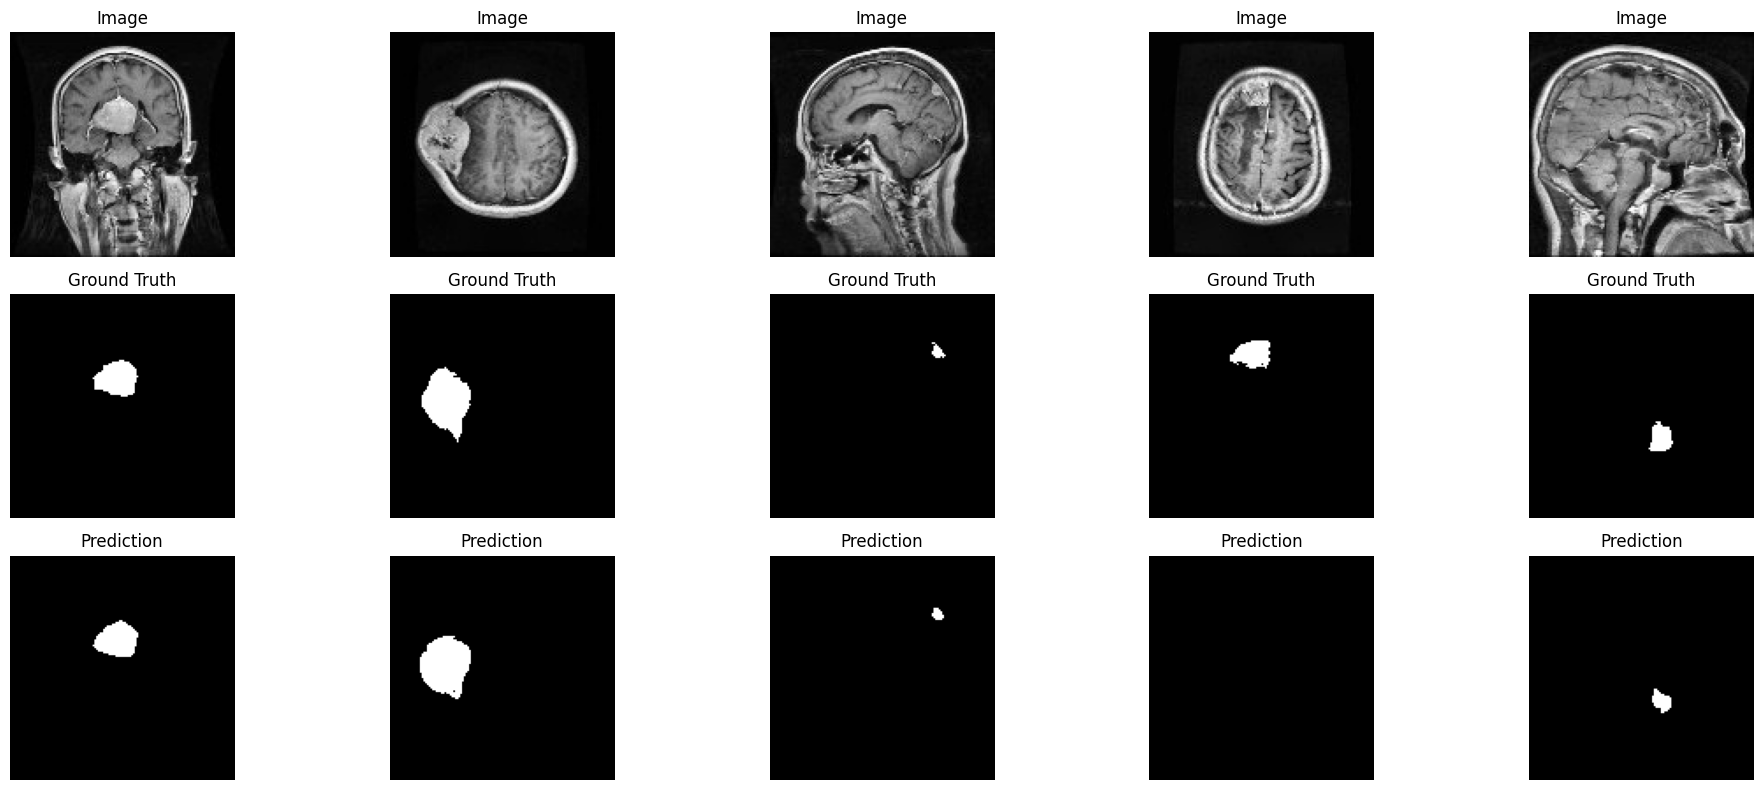

In [26]:
model.eval()
plt.figure(figsize=(20, 8))

for i in range(5):
    image, mask = val_ds[i]

    # Move image to device and predict
    with torch.no_grad():
        pred = model(image.unsqueeze(0).to(device))
        pred = pred.squeeze().cpu().numpy()

    # Plot original image (grayscale)
    plt.subplot(3, 5, i + 1)
    plt.imshow(image.squeeze().numpy(), cmap='gray')
    plt.title("Image")
    plt.axis('off')

    # Plot ground truth mask
    plt.subplot(3, 5, i + 6)
    plt.imshow(mask.squeeze().numpy(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    # Plot predicted mask (thresholded)
    plt.subplot(3, 5, i + 11)
    plt.imshow(pred > 0.5, cmap='gray')
    plt.title("Prediction")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [24]:
class UNetWithClassifier(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, num_classes=2):
        super().__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.pool = nn.MaxPool2d(2)

        # Encoder
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)

        # Bottleneck
        self.bottleneck = conv_block(256, 512)

        # Decoder
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final_seg = nn.Conv2d(64, out_channels, kernel_size=1)

        # Classifier head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # [B, 512, 1, 1]
            nn.Flatten(),                  # [B, 512]
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 4)     # For binary: num_classes=1
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        # Bottleneck
        b = self.bottleneck(self.pool(e3))

        # Classification head
        class_logits = self.classifier(b)

        # Decoder
        d3 = self.up3(b)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))
        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        seg_output = torch.sigmoid(self.final_seg(d1))

        return seg_output, class_logits


In [25]:
class SegmentationDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = cv2.imread(row['image_path'], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(row['mask_path'], cv2.IMREAD_GRAYSCALE)
        label = row['label']  # <- This is the missing part

        if image is None:
            raise FileNotFoundError(f"Image not found: {row['image_path']}")
        if mask is None:
            raise FileNotFoundError(f"Mask not found: {row['mask_path']}")

        image = np.expand_dims(image, axis=0).astype(np.float32) / 255.0
        mask = (mask > 127).astype(np.float32)
        mask = np.expand_dims(mask, axis=0)

        return torch.tensor(image), torch.tensor(mask), torch.tensor(label, dtype=torch.long)


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Split dataset
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

# Dataset and DataLoader (assumes label is included)
train_ds = SegmentationDataset(train_df)  # should return image, mask, label
val_ds = SegmentationDataset(val_df)
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=4)

# Model
model = UNetWithClassifier(in_channels=1, out_channels=1, num_classes=4)


# Optimizer and Losses
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion_seg = nn.BCELoss()
criterion_cls = nn.CrossEntropyLoss()  # or BCEWithLogitsLoss if binary label

alpha = 0.5  # weight for classification loss

# Training loop
for epoch in range(10):  
    model.train()
    train_loss = 0
    for imgs, masks, labels in train_dl:
        imgs, masks, labels = imgs.to(device), masks.to(device), labels.to(device)

        seg_output, class_logits = model(imgs)

        loss_seg = criterion_seg(seg_output, masks)
        loss_cls = criterion_cls(class_logits, labels)
        loss = loss_seg + alpha * loss_cls

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_dice, val_iou, val_acc = 0, 0, 0
    with torch.no_grad():
        for imgs, masks, labels in val_dl:
            imgs, masks, labels = imgs.to(device), masks.to(device), labels.to(device)
            seg_output, class_logits = model(imgs)

            preds_bin = (seg_output > 0.5).float()
            val_dice += dice_score(preds_bin, masks)
            val_iou += iou_score(preds_bin, masks)

            pred_labels = torch.argmax(class_logits, dim=1)
            val_acc += (pred_labels == labels).float().mean().item()

    print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train_dl):.4f} | "
          f"Val Dice: {val_dice/len(val_dl):.4f} | Val IoU: {val_iou/len(val_dl):.4f} | "
          f"Val Acc: {val_acc/len(val_dl):.4f}")


Epoch 1 | Train Loss: 0.5963 | Val Dice: 0.0000 | Val IoU: 0.0000 | Val Acc: 0.5429
Epoch 2 | Train Loss: 0.4521 | Val Dice: 0.0445 | Val IoU: 0.0276 | Val Acc: 0.5530
Epoch 3 | Train Loss: 0.3790 | Val Dice: 0.0060 | Val IoU: 0.0033 | Val Acc: 0.6515
Epoch 4 | Train Loss: 0.2964 | Val Dice: 0.0975 | Val IoU: 0.0640 | Val Acc: 0.8056
Epoch 5 | Train Loss: 0.2611 | Val Dice: 0.2815 | Val IoU: 0.2174 | Val Acc: 0.8636
Epoch 6 | Train Loss: 0.2337 | Val Dice: 0.2572 | Val IoU: 0.2028 | Val Acc: 0.8258
Epoch 7 | Train Loss: 0.2188 | Val Dice: 0.3476 | Val IoU: 0.2807 | Val Acc: 0.8485
Epoch 8 | Train Loss: 0.2058 | Val Dice: 0.4493 | Val IoU: 0.3611 | Val Acc: 0.8611
Epoch 9 | Train Loss: 0.1820 | Val Dice: 0.4425 | Val IoU: 0.3602 | Val Acc: 0.8864
Epoch 10 | Train Loss: 0.1710 | Val Dice: 0.4664 | Val IoU: 0.3882 | Val Acc: 0.9167


In [44]:
# ------------------- Attention Block -------------------
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

# ------------------- Attention U-Net with Classifier -------------------
class AttentionUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, num_classes=4):
        super().__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.pool = nn.MaxPool2d(2)

        # Encoder
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        # Bottleneck
        self.bottleneck = conv_block(512, 1024)

        # Attention blocks
        self.att4 = AttentionBlock(512, 512, 256)
        self.att3 = AttentionBlock(256, 256, 128)
        self.att2 = AttentionBlock(128, 128, 64)
        self.att1 = AttentionBlock(64, 64, 32)

        # Decoder
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = conv_block(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

        # Classification head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # [B, 1024, 1, 1]
            nn.Flatten(),                  # [B, 1024]
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        # Bottleneck
        b = self.bottleneck(self.pool(e4))

        # Classification head
        class_logits = self.classifier(b)

        # Decoder with attention
        d4 = self.up4(b)
        e4 = self.att4(d4, e4)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = self.up3(d4)
        e3 = self.att3(d3, e3)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.up2(d3)
        e2 = self.att2(d2, e2)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        e1 = self.att1(d1, e1)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        seg_output = torch.sigmoid(self.final(d1))

        return seg_output, class_logits

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Split dataset
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

# Dataset and DataLoader (assumes label is included)
train_ds = SegmentationDataset(train_df)  # should return image, mask, label
val_ds = SegmentationDataset(val_df)
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=4)

# Model
model = AttentionUNet(in_channels=1, out_channels=1, num_classes=4).to(device)



# Optimizer and Losses
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion_seg = nn.BCELoss()
criterion_cls = nn.CrossEntropyLoss()  # or BCEWithLogitsLoss if binary label

alpha = 0.5  # weight for classification loss

# Training loop
for epoch in range(10):  
    model.train()
    train_loss = 0
    for imgs, masks, labels in train_dl:
        imgs, masks, labels = imgs.to(device), masks.to(device), labels.to(device)

        seg_output, class_logits = model(imgs)

        loss_seg = criterion_seg(seg_output, masks)
        loss_cls = criterion_cls(class_logits, labels)
        loss = loss_seg + alpha * loss_cls

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_dice, val_iou, val_acc = 0, 0, 0
    with torch.no_grad():
        for imgs, masks, labels in val_dl:
            imgs, masks, labels = imgs.to(device), masks.to(device), labels.to(device)
            seg_output, class_logits = model(imgs)

            preds_bin = (seg_output > 0.5).float()
            val_dice += dice_score(preds_bin, masks)
            val_iou += iou_score(preds_bin, masks)

            pred_labels = torch.argmax(class_logits, dim=1)
            val_acc += (pred_labels == labels).float().mean().item()

    print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train_dl):.4f} | "
          f"Val Dice: {val_dice/len(val_dl):.4f} | Val IoU: {val_iou/len(val_dl):.4f} | "
          f"Val Acc: {val_acc/len(val_dl):.4f}")


Epoch 1 | Train Loss: 0.6380 | Val Dice: 0.0000 | Val IoU: 0.0000 | Val Acc: 0.3283
Epoch 2 | Train Loss: 0.5939 | Val Dice: 0.5015 | Val IoU: 0.4064 | Val Acc: 0.3409
Epoch 3 | Train Loss: 0.5749 | Val Dice: 0.5240 | Val IoU: 0.4246 | Val Acc: 0.3409
Epoch 4 | Train Loss: 0.4098 | Val Dice: 0.5477 | Val IoU: 0.4453 | Val Acc: 0.7298
Epoch 5 | Train Loss: 0.3084 | Val Dice: 0.2903 | Val IoU: 0.2166 | Val Acc: 0.7298
Epoch 6 | Train Loss: 0.2398 | Val Dice: 0.5690 | Val IoU: 0.4827 | Val Acc: 0.8535
Epoch 7 | Train Loss: 0.1754 | Val Dice: 0.5945 | Val IoU: 0.5089 | Val Acc: 0.9141
Epoch 8 | Train Loss: 0.1439 | Val Dice: 0.6373 | Val IoU: 0.5525 | Val Acc: 0.8788
Epoch 9 | Train Loss: 0.1258 | Val Dice: 0.5813 | Val IoU: 0.4958 | Val Acc: 0.8864
Epoch 10 | Train Loss: 0.1168 | Val Dice: 0.6572 | Val IoU: 0.5667 | Val Acc: 0.9444


In [46]:
def evaluate_model(model, dataloader):
    model.eval()
    dice_total, iou_total, acc_total = 0, 0, 0
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            if isinstance(preds, tuple):  # If model returns (seg_output, class_logits)
                preds = preds[0]
            preds_bin = (preds > 0.5).float()

            dice_total += dice_score(preds_bin, masks)
            iou_total += iou_score(preds_bin, masks)
            acc_total += pixel_accuracy(preds_bin, masks)

    n = len(dataloader)
    return {
        "Dice": dice_total / n,
        "IoU": iou_total / n,
        "Pixel Accuracy": acc_total / n
    }


In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate models
unet_model = UNet(in_channels=1, out_channels=1).to(device)
cls_model = UNetWithClassifier(in_channels=1, out_channels=1, num_classes=4).to(device)
attn_model = AttentionUNet(in_channels=1, out_channels=1, num_classes=4).to(device)

# Evaluate
metrics_unet = evaluate_model(unet_model, val_dl)
metrics_cls = evaluate_model(cls_model, val_dl)
metrics_attn = evaluate_model(attn_model, val_dl)







ValueError: too many values to unpack (expected 2)